In [1]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from torch.utils.data import Dataset, DataLoader
import os
import librosa
import numpy as np
import tensorflow as tf

/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = os.path.join("..","models", "cnn_model.keras")
cnn_model = tf.keras.models.load_model(model_path)

In [3]:
test_dir = "/Users/shanoonissaka/Documents/school/thesis-project/datasets/audio/testing"

In [4]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/transformers/configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/Users/shanoonissaka/Documents/school/thesis-project/code/audio-detect/audio-detect/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be re

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [6]:
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(np.vstack(features), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [7]:
def load_audio_files(directory, sr=16000):
    audio_data = []
    labels = []
    class_labels = {label: i for i, label in enumerate(os.listdir(directory))}  # Assign numerical labels

    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file)
                try:
                    audio, _ = librosa.load(file_path, sr=sr)  # Load audio
                    audio_data.append(audio)
                    labels.append(class_labels[label])  # Convert label to integer
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
    
    return np.array(audio_data, dtype=object), np.array(labels)

In [8]:
# Extract features and labels from the DataLoader
def dataloader_to_numpy(dataloader):
    feature_list, label_list = [], []
    for batch in dataloader:
        inputs, labels = batch
        feature_list.append(inputs.cpu().numpy())  # Convert to NumPy
        label_list.append(labels.cpu().numpy())

    flat_features = np.vstack(feature_list)  # Stack into single NumPy array
    flat_labels = np.hstack(label_list)  # Stack labels

    return flat_features, flat_labels

In [9]:
def extract_wav2vec2_features(audio_data):
    features = []
    
    for audio in audio_data:
        inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move to GPU if available
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        features.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())  # Take mean across time
        
    return np.array(features)

In [10]:
test_features, test_labels = load_audio_files(test_dir)
wav_vec_test_features = extract_wav2vec2_features(test_features)
test_dataset = AudioDataset(wav_vec_test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
flatten_test_features, flatten_test_labels = dataloader_to_numpy(test_loader)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [13]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(test_labels)
feature_reshape = np.array(wav_vec_test_features).reshape(-1, 24, 32, 1)


In [14]:
y_pred_probs = cnn_model.predict(feature_reshape)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

29/29 [==============================] - 0s 3ms/step


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(encoded_labels, y_pred_labels)
precision = precision_score(encoded_labels, y_pred_labels, average='binary')  # use 'macro' or 'weighted' if >2 classes
recall = recall_score(encoded_labels, y_pred_labels, average='binary')
f1 = f1_score(encoded_labels, y_pred_labels, average='binary')
conf_matrix = confusion_matrix(encoded_labels, y_pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9069
Precision: 0.9420
Recall: 0.8399
F1 Score: 0.8880
Confusion Matrix:
[[497  21]
 [ 65 341]]


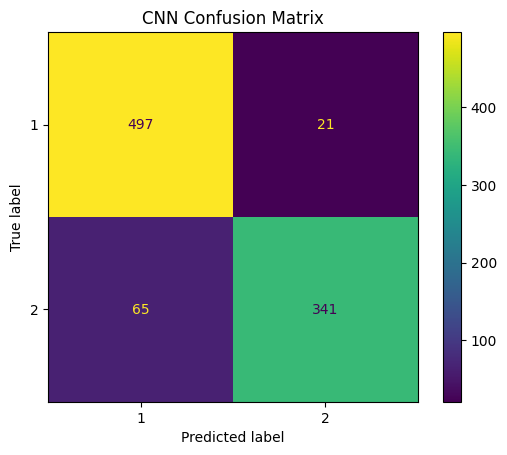

In [20]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(encoded_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.viridis)
plt.title("CNN Confusion Matrix")
plt.show()